In [9]:

import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from matrix_algorithms.difference_matrix import Difference_Matrix



In [10]:
def fused_lasso(D_k_beta_u,alpha,n,k,lambda_,rho):
    """Fused Lasso Wrapper Adapted to ADMM"""
    
    # feature matrix is identity matrix
    X=np.eye(n-k-1)

    # cvxpy variables
    alpha_hat = cvx.Variable(n-k-1)

    # warm start
    alpha_hat.value = alpha.flatten()
    
    # generate difference matrix
    if k<0:
        forwardDiff = alpha_hat[1:] - alpha_hat[:-1]
    else:
        # second difference is difference of first difference
        for i in range(0,k+1):
            forwardDiff = alpha_hat[1:] - alpha_hat[:-1]

    # fused lasso objective of mse + lambda/rho*norm
    objective = cvx.Minimize(.5*cvx.sum_squares(X@alpha_hat - D_k_beta_u) + lambda_/rho*cvx.norm(forwardDiff,1))
 
    prob = cvx.Problem(objective)
    
    result = prob.solve(warm_start=True)


    return alpha_hat.value.reshape(-1,1)



In [119]:
def specialized_admm(y: np.ndarray, D:Difference_Matrix , lambda_: float):
    """Specialized ADMM Implementation for Trend Filtering

    """

    # construct difference matrix of order k (not k-1) from original difference matrix
    n = y.shape[0]
    k=D.k
    y=y.reshape(-1,1)
    D = D.compute_k_difference(k-1)
    D_ = D
    D_t_D = D_.T.dot(D_)


   # set max iterations
    MAX_ITER = 250

    # initialize variables with guesses
    beta = y.copy()

    # alpha is in R^{n-k-1 x 1}
    alpha = D_.dot(beta)
    u = np.zeros([n-k, 1])

    # ref. sets rho to lambda for stability
    rho=lambda_

    # Pre-compute to save some multiplications
    I = np.identity(n)
    rho_D_T= rho * D_.T
    Q = I + rho * D_t_D
    Q_inv = np.linalg.inv(Q)
    Q_inv_dot = Q_inv.dot

    # Calculate lambda_max (order k+1)
    D_k_1=Difference_Matrix(n, k=k)
    lambda_max= np.amax(np.absolute(np.linalg.inv(D_k_1.D.dot(D_k_1.D.T)).dot((D_k_1.D).dot(y))))

    for _ in range(MAX_ITER):

        # beta is in R^{n x 1}
        beta = Q_inv_dot(y+ rho_D_T.dot((alpha + u).reshape(-1,1 )))
      
        # precompute observation matrix
        D_k_beta_u=(D_@beta-u).flatten()

        # alpha is in R^{n-k-1 x 1}
        alpha = fused_lasso(D_k_beta_u,alpha,n,k-1,lambda_,rho)
            
        # update u
        u = u + alpha - D_.dot(beta)
            
    return beta


### Prep ADMM Implementation for TF Problem

Note the 

In [120]:
from matrix_algorithms.difference_matrix import Difference_Matrix

from basis.continous_tf import Continous_TF

PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [121]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=20000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]

regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
trade_price=regular_trades["Trade_Price"].values
trade_price=trade_price.reshape(-1,1)

D= Difference_Matrix(trade_price.shape[0],k=1)

### Results for Piecewise Linear Trend Filtering 

Two values of lambda are utilized 

In [123]:
beta_low=specialized_admm(trade_price,D,lambda_=50)

beta_high=specialized_admm(trade_price,D,lambda_=1000)


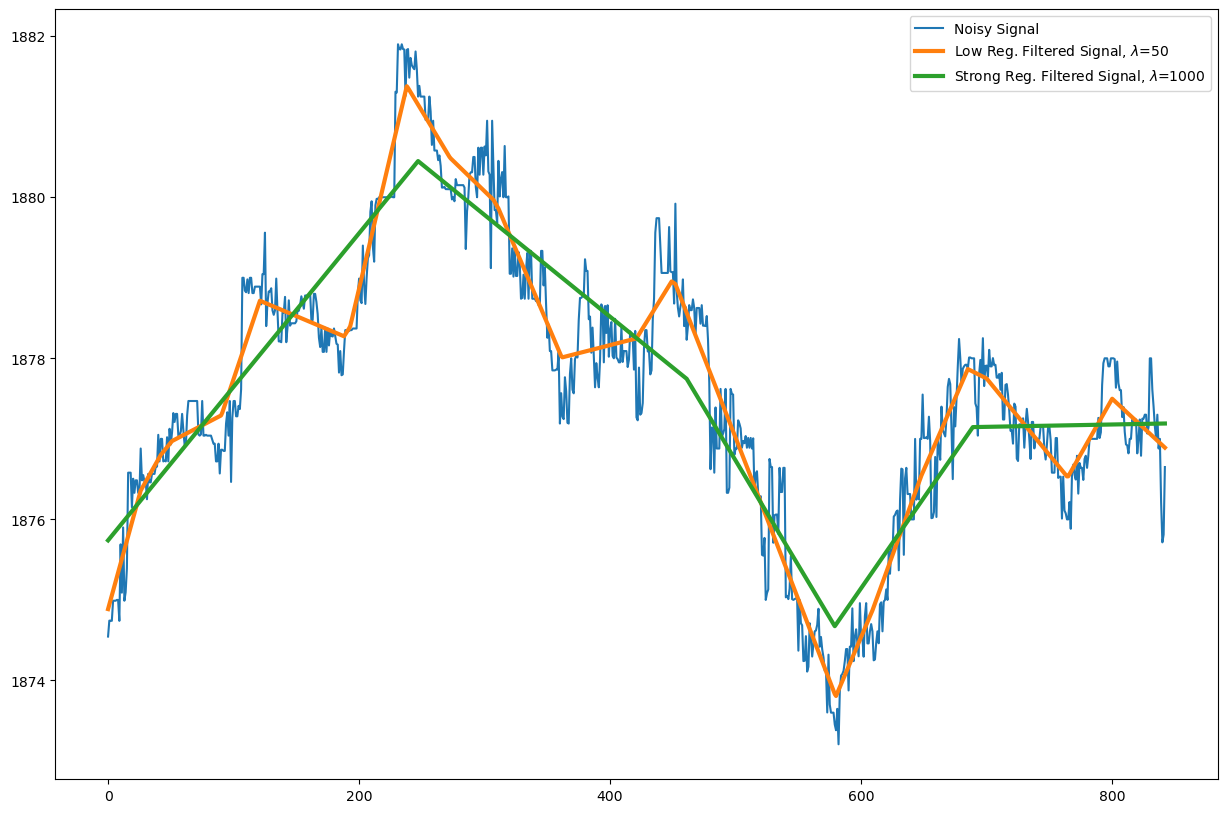

In [124]:
fig,ax=plt.subplots(figsize=(15,10))

ax.plot(trade_price,label="Noisy Signal")
ax.plot(beta_low,label=f"Low Reg. Filtered Signal, $\lambda$={50}",lw=3)
ax.plot(beta_high,label=f"Strong Reg. Filtered Signal, $\lambda$={1000}",lw=3)
ax.legend()

### Piecewise Cubic Trend Filtering with ADMM

In [129]:
D3= Difference_Matrix(trade_price.shape[0],k=3)

beta_cubic=specialized_admm(trade_price,D3,lambda_=1000)

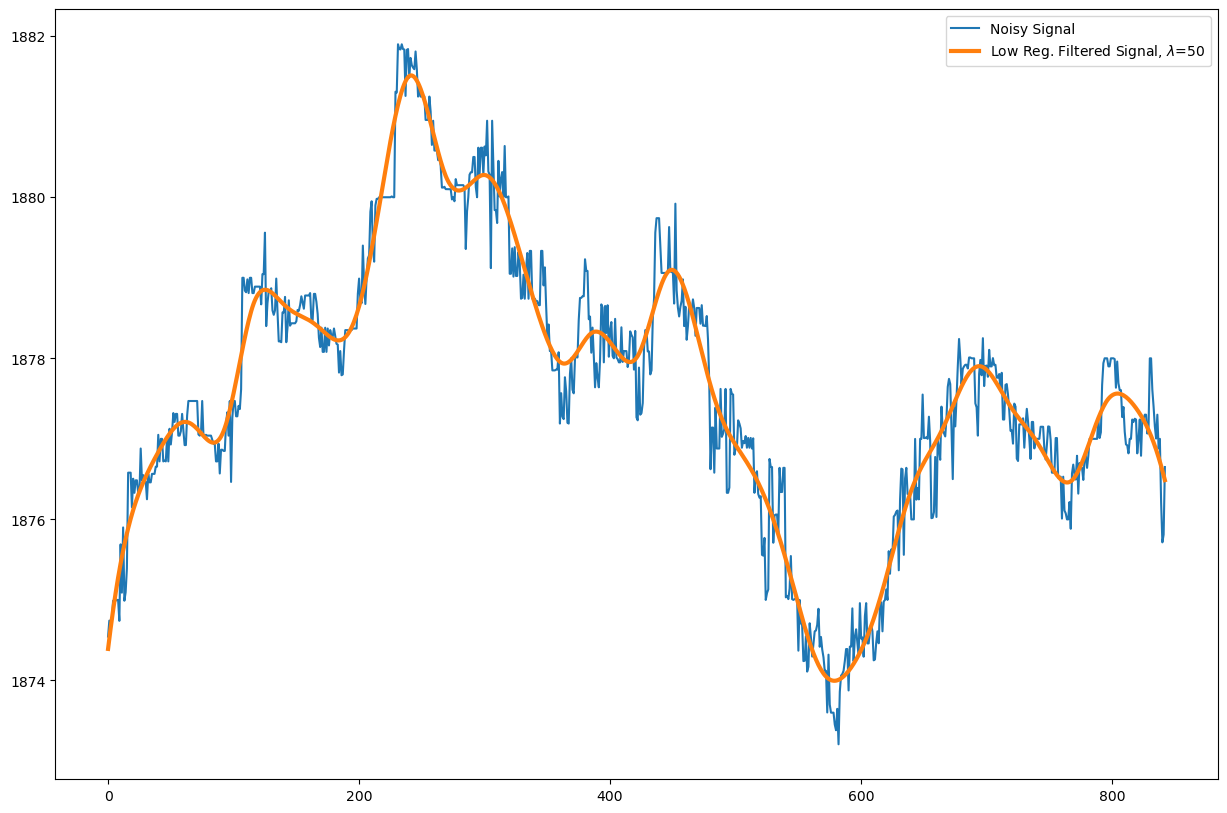

In [130]:
fig,ax=plt.subplots(figsize=(15,10))

ax.plot(trade_price,label="Noisy Signal")
ax.plot(beta_cubic,label=f"Low Reg. Filtered Signal, $\lambda$={50}",lw=3)

ax.legend()


### Piecewise Constant Trend Filtering with ADMM

In [131]:
D0= Difference_Matrix(trade_price.shape[0],k=0)

beta_constant=specialized_admm(trade_price,D0,lambda_=5)


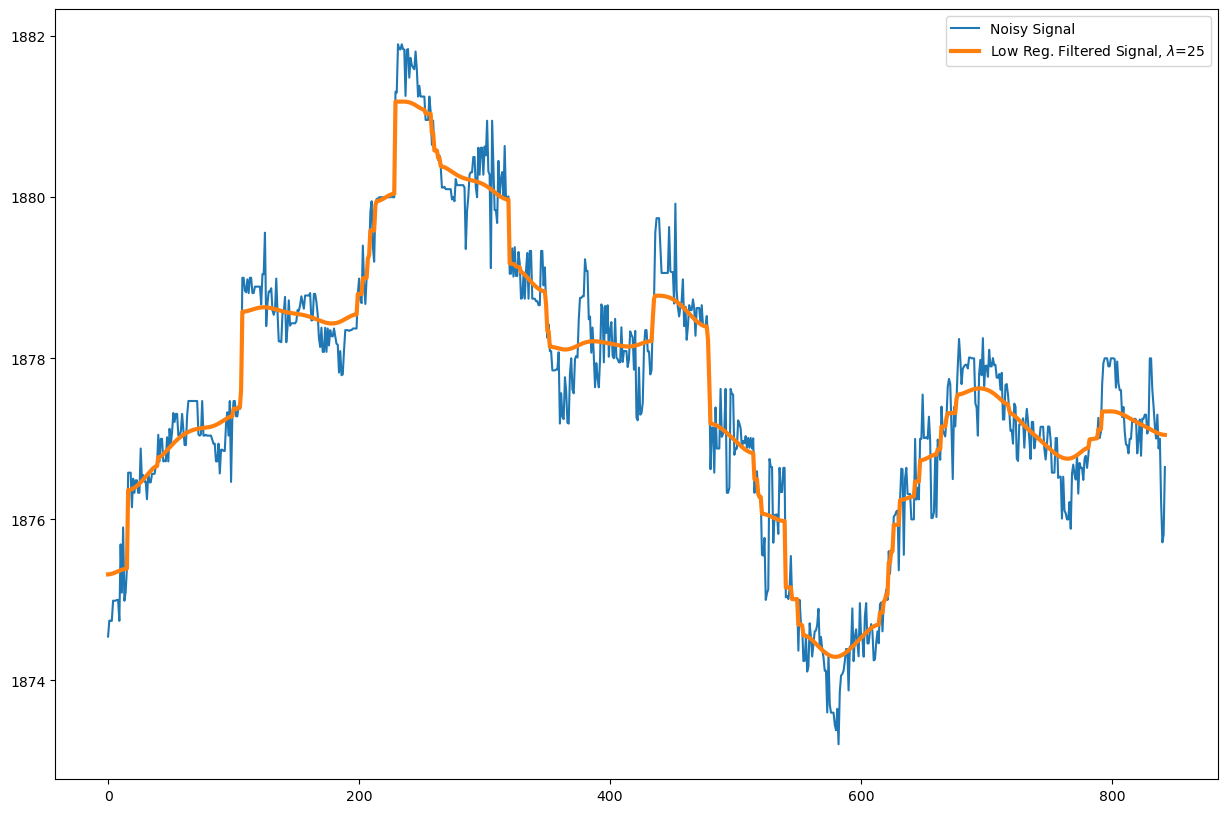

In [132]:
fig,ax=plt.subplots(figsize=(15,10))

ax.plot(trade_price,label="Noisy Signal")
ax.plot(beta_constant,label=f"Low Reg. Filtered Signal, $\lambda$={25}",lw=3)

ax.legend()
